# Introduction

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.


### Goal(s):

Predict how fit the candidate is based on their available information (variable fit)

Success Metric(s):

Rank candidates based on a fitness score.

Re-rank candidates when a candidate is starred.

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import requests
import zipfile
from io import BytesIO

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


Download Data:
https://docs.google.com/spreadsheets/d/117X6i53dKiO7w6kuA1g1TpdTlv1173h_dPlJt5cNNMU/edit?usp=sharing

In [2]:
data_og = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')
data = data_og

In [3]:
data.head()
pd.set_option('display.max_colwidth', None)

In [4]:
data.shape

(104, 5)

In [5]:
data

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
...,...,...,...,...,...
99,100,Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis,"Cape Girardeau, Missouri",103,NaN
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
102,103,Always set them up for Success,Greater Los Angeles Area,500+,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


#### Data Description

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

**Attributes** 

id : unique identifier for candidate (numeric)

job_title : job title for candidate (text)

location : geographical location for candidate (text)

connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target): fit - how fit the candidate is for the role? (numeric, probability between 0-1)

### Missing Data

Confirm we don't have any fields missing for the 104 entries. 

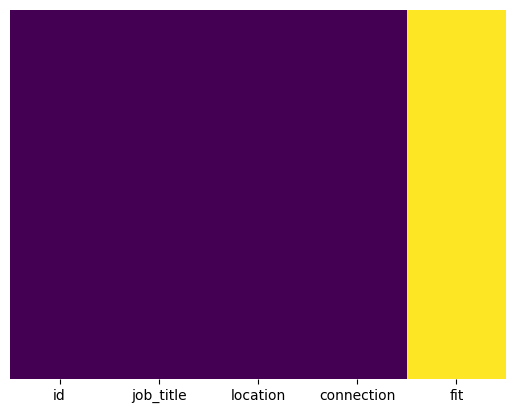

In [7]:
missing_data = sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

The fit or the target is not really needed for the ranking alogrithms so I'll go ahead and drop this field. 

In [8]:
data = data.drop('fit', axis=1)

In [9]:
data

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+
...,...,...,...,...
99,100,Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis,"Cape Girardeau, Missouri",103
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49
102,103,Always set them up for Success,Greater Los Angeles Area,500+


## Duplicates

In [10]:
data.duplicated().any()

False

This is most likely due to the unique ID column

In [11]:
data.drop_duplicates(subset = ['job_title', 'location', 'connection'], keep = 'first', inplace = True)

In [12]:
data.shape

(53, 4)

In [13]:
data.head()

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+


# Data Wrangling 

### Functions for cleaning texts

In [14]:
def remove_numericals(text):
    cleaned = re.sub(r'\d+', '', text)
    return cleaned
def remove_extra_space(text):
    cleaned = re.sub(r"\s+", ' ', text).strip()
    return cleaned
def remove_symbols(text):
    cleaned = re.sub(r"[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n -' ]", " ", text)
    return cleaned

## Location

In [15]:
data['location'].nunique()

41

<AxesSubplot:>

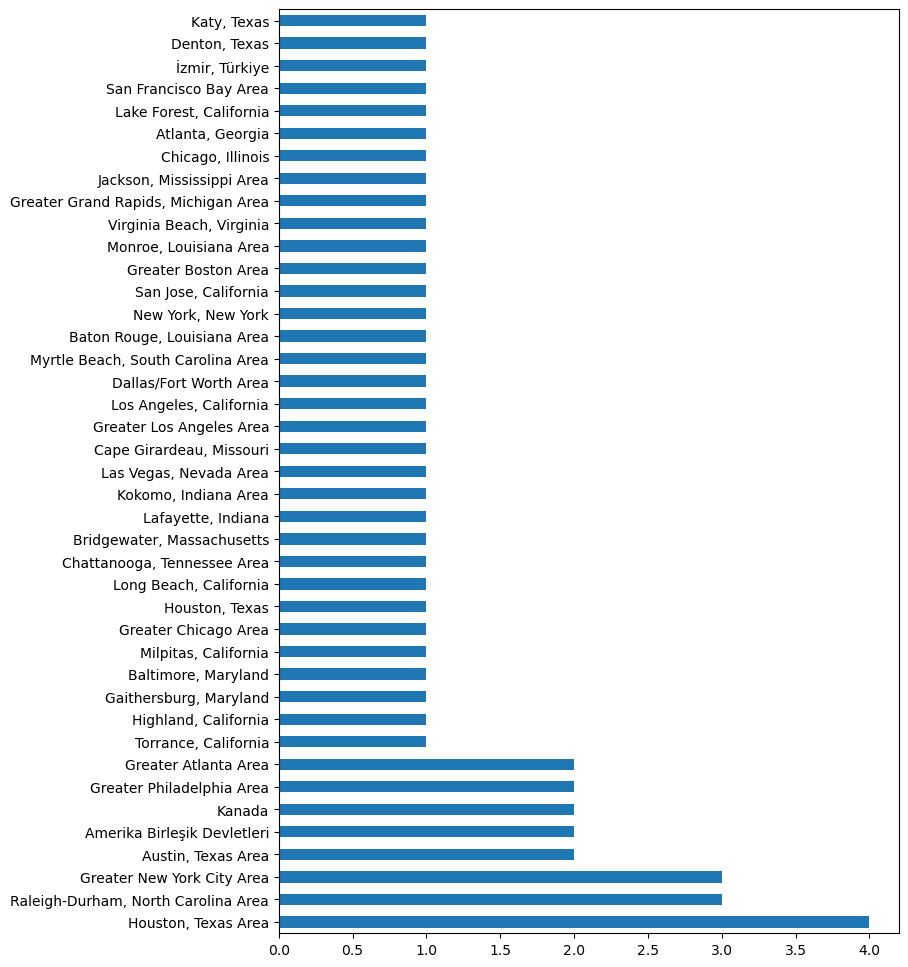

In [16]:
data['location'].value_counts().plot(kind='barh', figsize=(8,12))

#### Identifying spurious entries and data cleaning

In [17]:
data[data['location'] == 'Kanada']

,id,job_title,location,connection
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+
6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61


Humber college is in Canada and Kanada is a common spelling for "Canada" in many foreign languages. So I'll change this to Canada as majority of the vocabulary in this dataset is in English. 

In [18]:
data['location'] = data['location'].replace('Kanada','Canada')

In [19]:
data[data['location'] == 'İzmir, Türkiye']

,id,job_title,location,connection
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+


In [20]:
data['location'] = data['location'].replace('İzmir, Türkiye','Izmir, Turkey')

In [21]:
data[data['location'] == 'Amerika Birleşik Devletleri']

,id,job_title,location,connection
77,78,Human Resources Generalist at Schwan's,Amerika Birleşik Devletleri,500+
93,94,Seeking Human Resources Opportunities. Open to travel and relocation.,Amerika Birleşik Devletleri,415


Amerika Birleşik Devletleri is just the USA in Turkish. 

In [22]:
data['location'] = data['location'].replace('Amerika Birleşik Devletleri','United States of America')

In [23]:
data[data['location'] == 'Houston, Texas']

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85


In [24]:
data['location'] = data['location'].replace('Houston, Texas Area','Houston, Texas')

#### Clean Location text

In [25]:
data['location'] = data['location'].str.lower()

In [26]:
data['location'] = data['location'].apply(lambda x: remove_numericals(x))
data['location'] = data['location'].apply(lambda x: remove_symbols(x))
data['location'] = data['location'].apply(lambda x: remove_extra_space(x))

In [27]:
data.head()

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,houston texas,85
1,2,Native English Teacher at EPIK (English Program in Korea),canada,500+
2,3,Aspiring Human Resources Professional,raleigh durham north carolina area,44
3,4,People Development Coordinator at Ryan,denton texas,500+
4,5,Advisory Board Member at Celal Bayar University,izmir turkey,500+


## Job Title

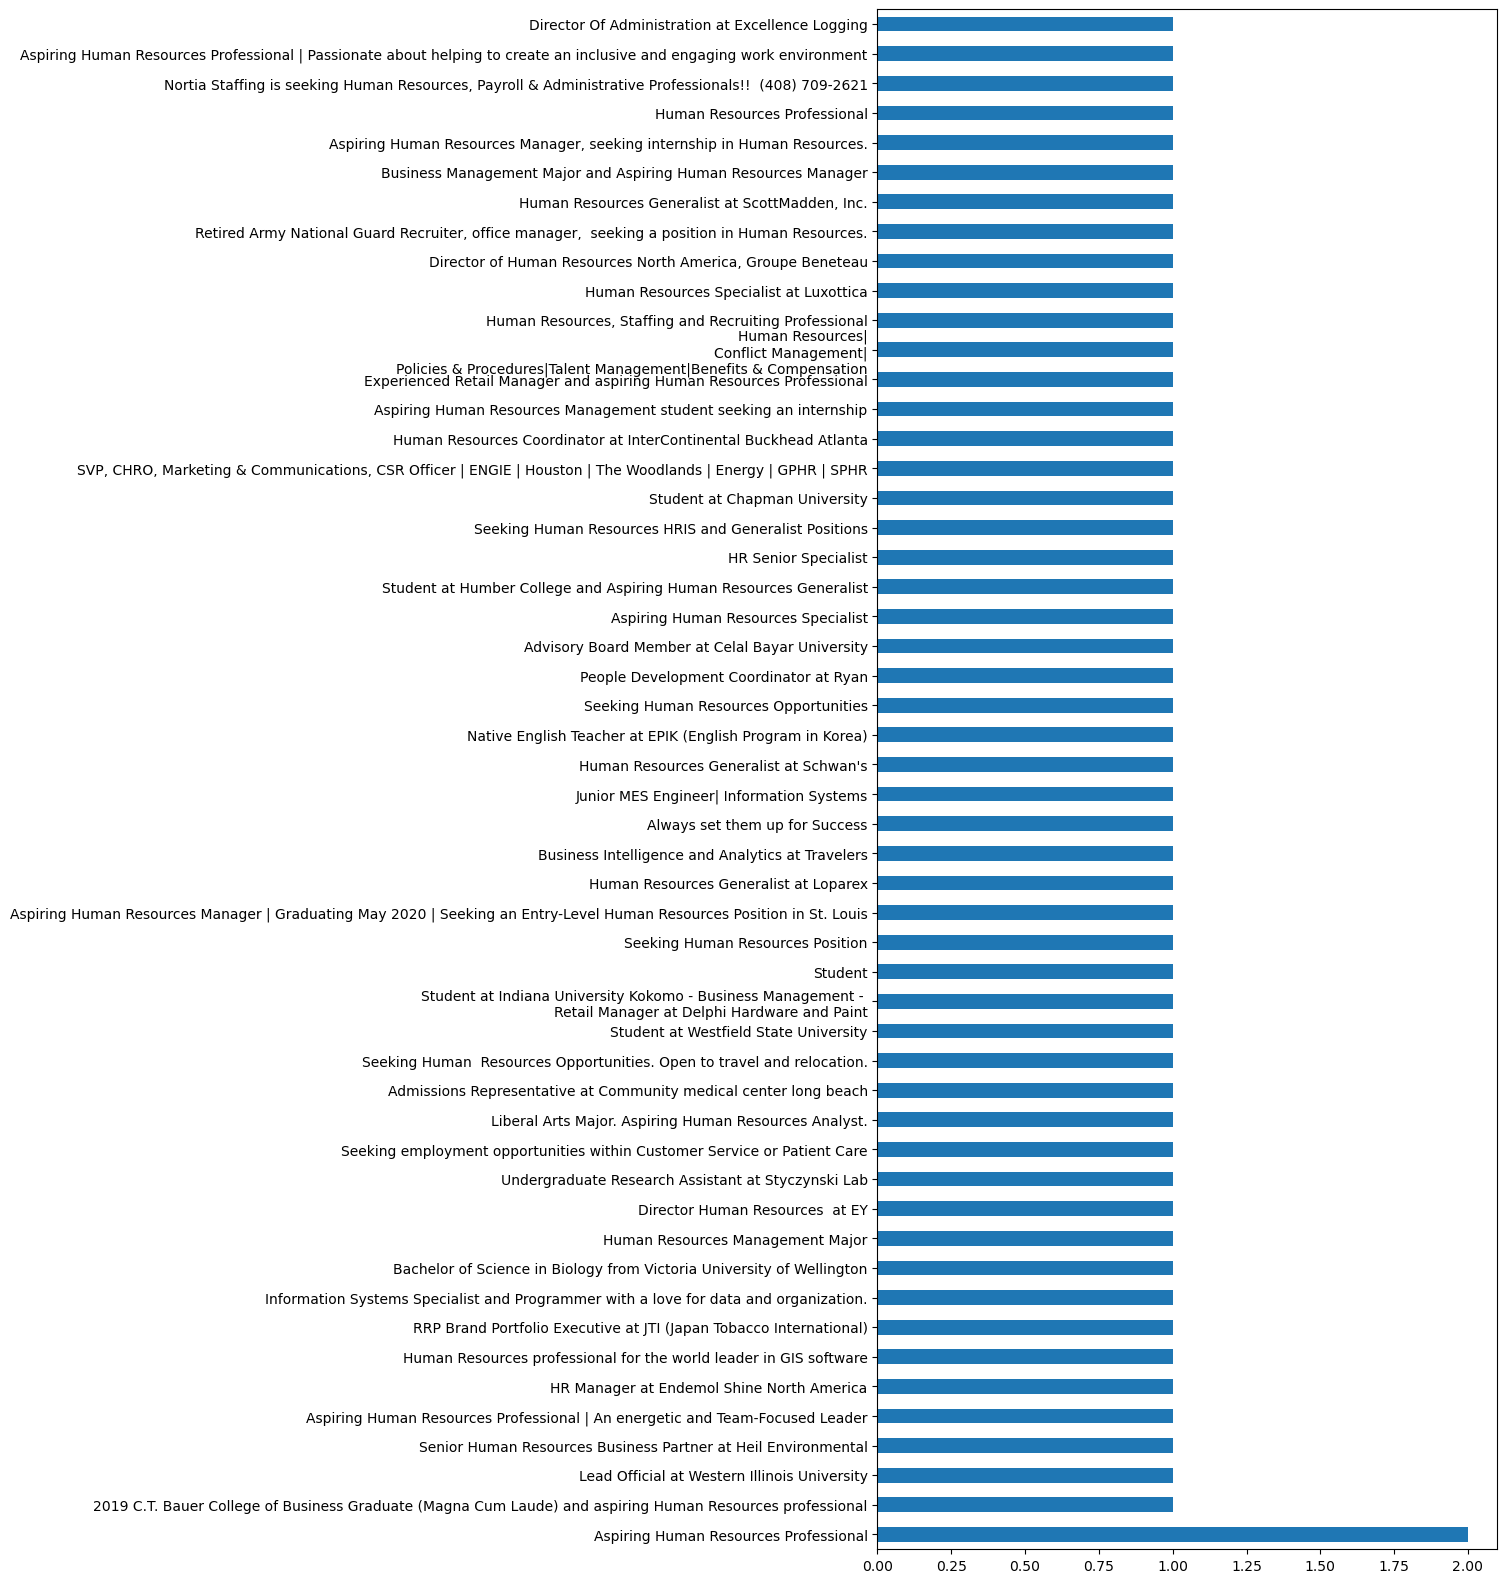

In [28]:
data['job_title'].value_counts().plot(kind='barh', figsize=(8,20))
plt.show();

In [29]:
data['job_title'] = data['job_title'].str.lower()

In [30]:
#remove symbols and numbers from job titles
data['job_title'] = data['job_title'].apply(lambda x: remove_numericals(x))
data['job_title'] = data['job_title'].apply(lambda x: remove_symbols(x))

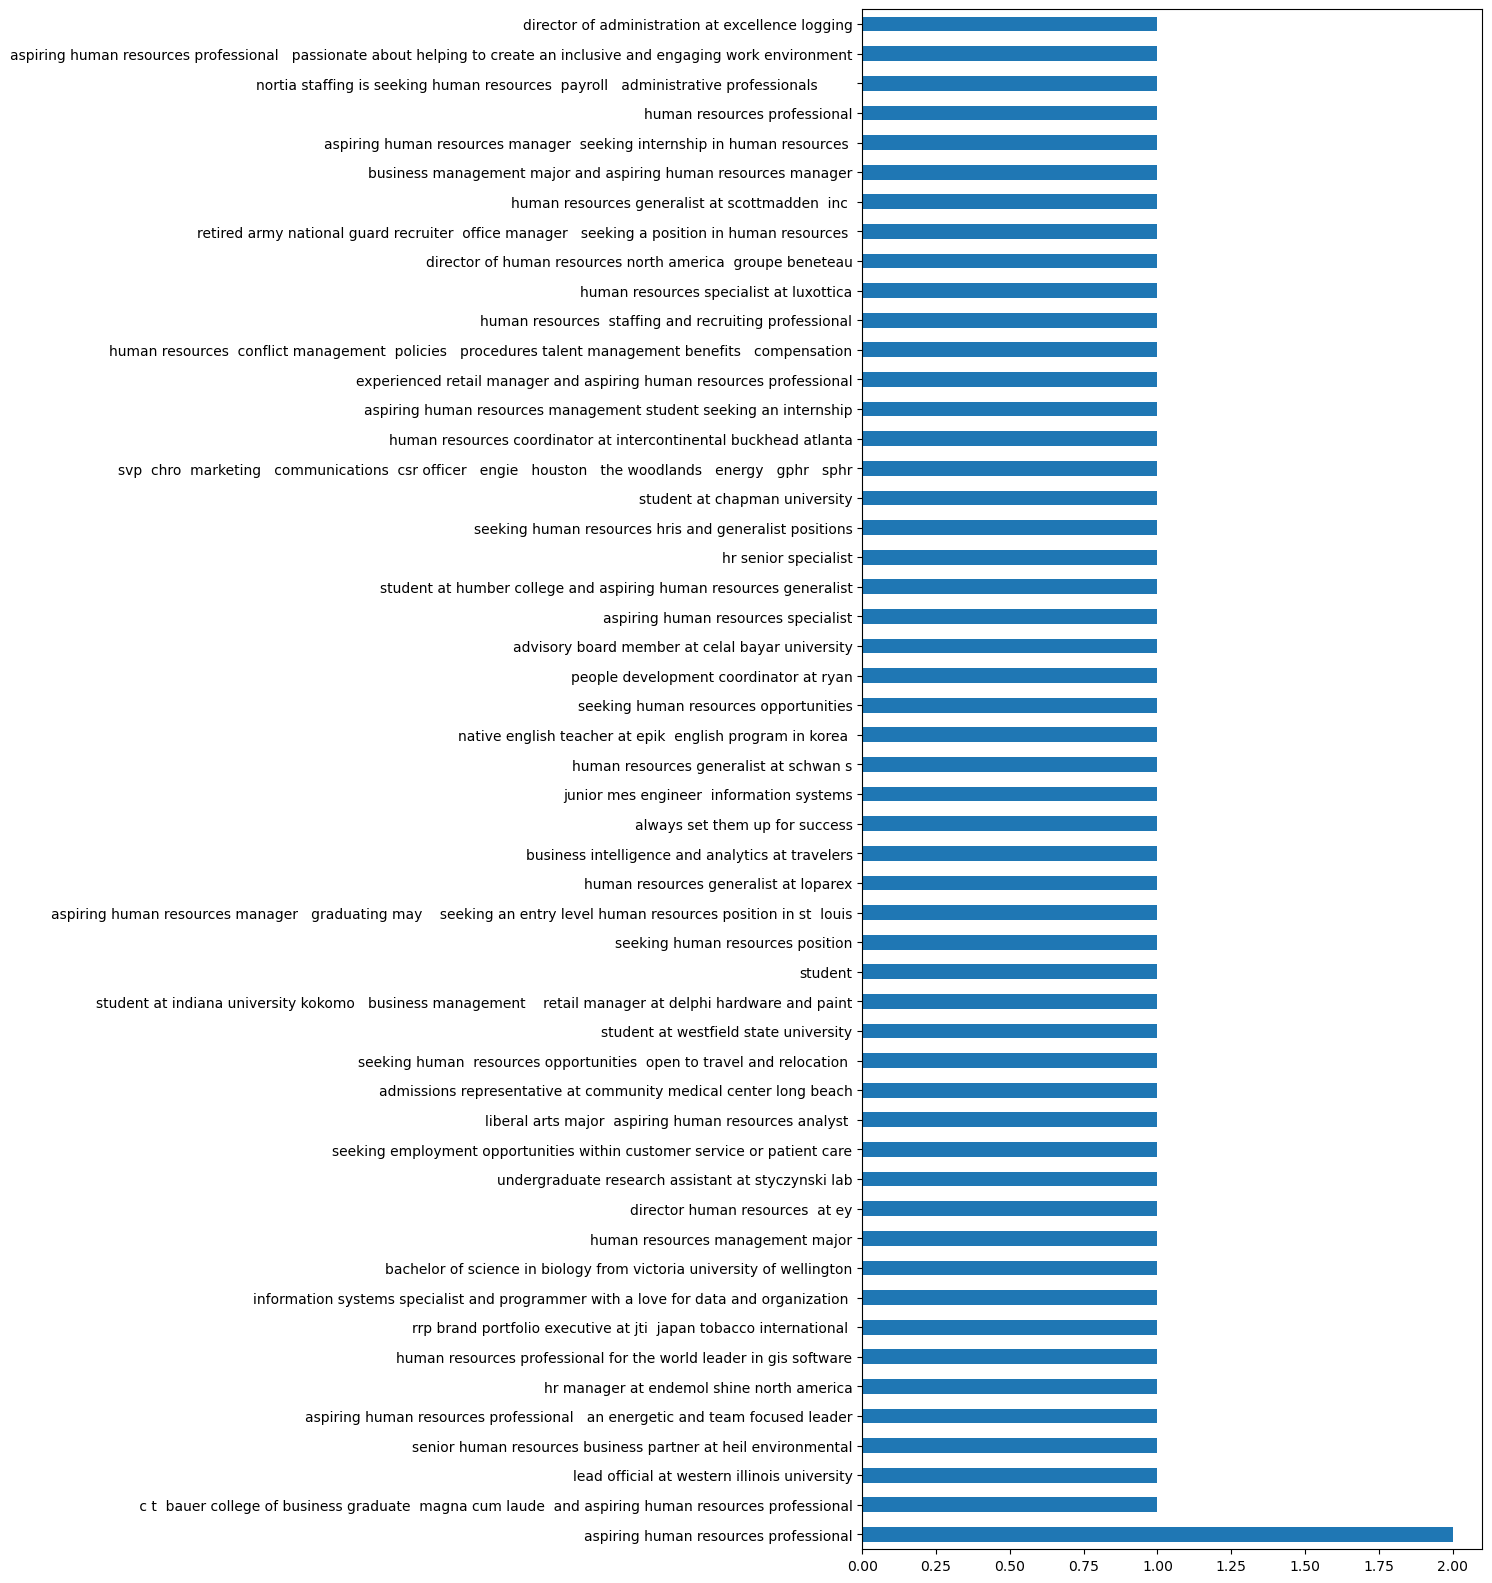

In [31]:
data['job_title'].value_counts().plot(kind='barh', figsize=(8,20))
plt.show();

The removal of the punctuation and symbols has left quite a few empty spaces, so these need to be removed. Also, there are quite a few abreviations that will be worth expanding. Given the small size of the corpus, I'll just do these manually. There are also a few accronyms that we can omit as their expanded forms are already in the entries. 

In [32]:
# delete 'jti' and 'epik' as they are already expanded in the text
data['job_title'] = data['job_title'].replace(r'jti',r'', regex=True)
data['job_title'] = data['job_title'].replace(r'epik',r'', regex=True)

In [33]:
#expand contractions
data['job_title'] = data['job_title'].str.replace('mes','manufacturing execution system')
data['job_title'] = data['job_title'].str.replace('rrp','reduced risk product')
data['job_title'] = data['job_title'].str.replace('gis', 'graphic information system')
data['job_title'] = data['job_title'].str.replace('svp','senior vice president')
data['job_title'] = data['job_title'].str.replace('chro','chief human resources officer')
data['job_title'] = data['job_title'].str.replace('csr' , 'corporate social responsibility')
data['job_title'] = data['job_title'].str.replace('gphr', 'global professional human resources')
data['job_title'] = data['job_title'].str.replace('sphr', 'senior professional human resources')
data['job_title'] = data['job_title'].str.replace('hris','human resources information system')
data['job_title'] = data['job_title'].str.replace('hr', 'human resources')

In [34]:
#remove extra space
data['job_title'] = data['job_title'].apply(lambda x: remove_extra_space(x))

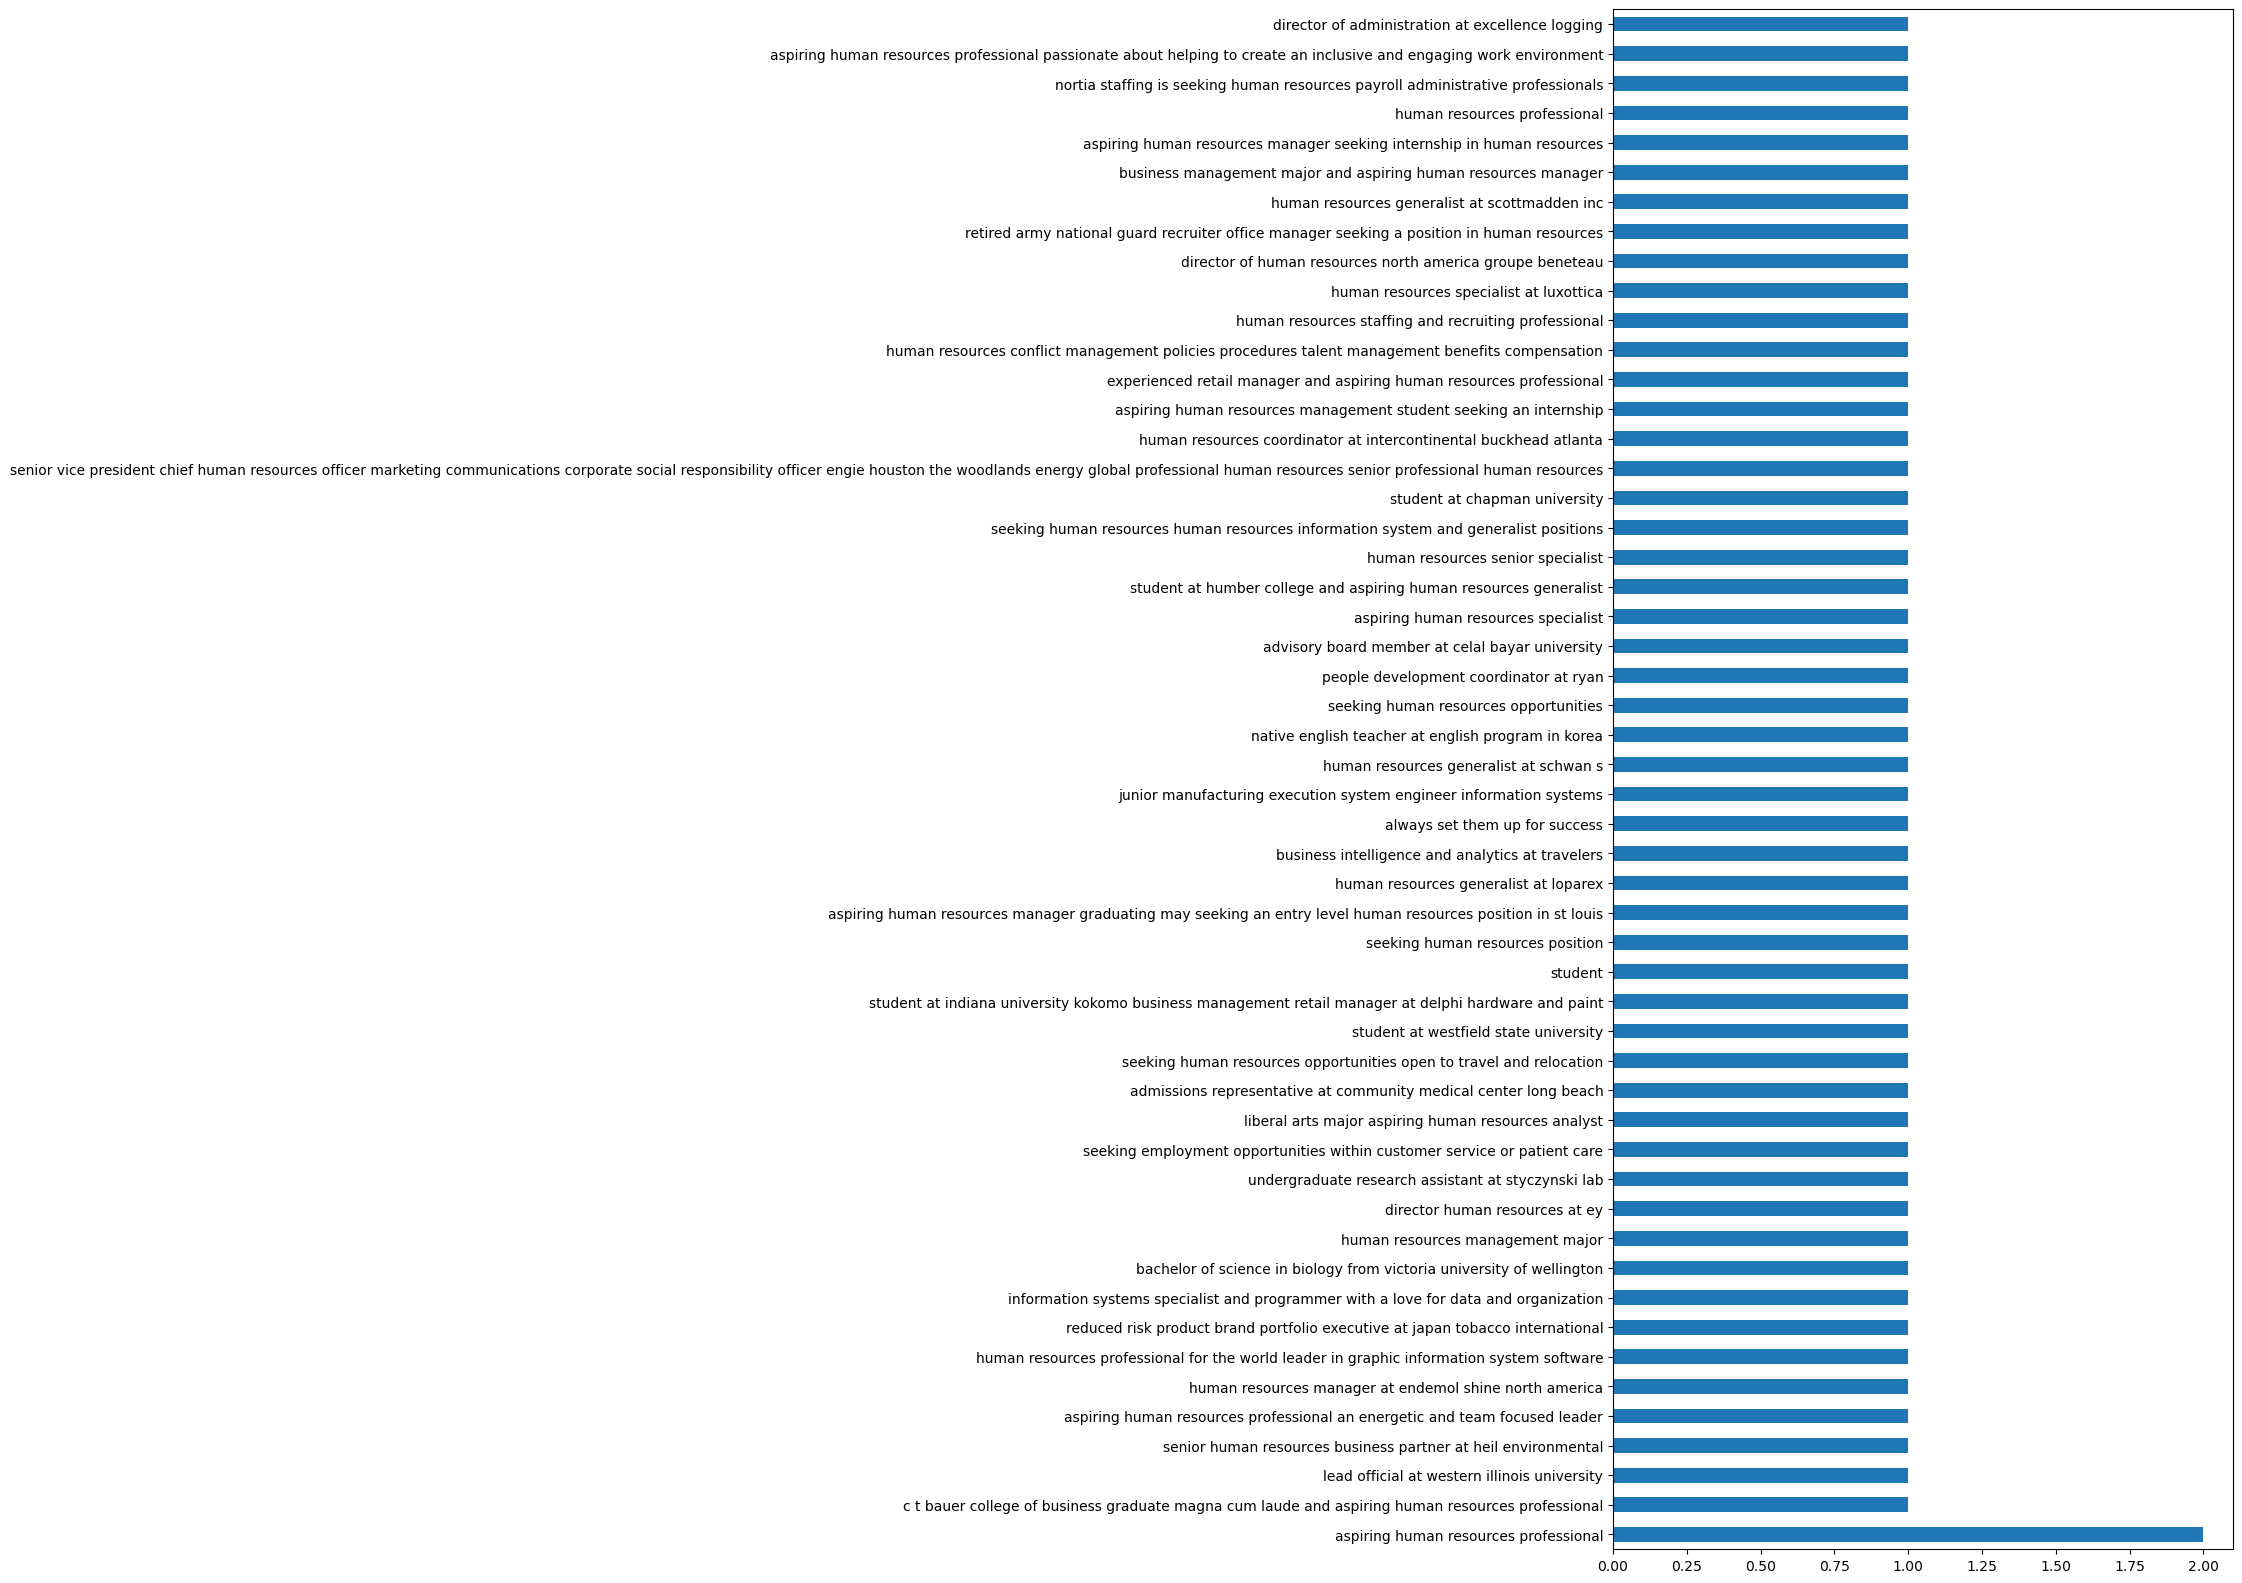

In [35]:
data['job_title'].value_counts().plot(kind='barh', figsize=(8,20))
plt.show();

#### Spurious entries

In [36]:
data[data['job_title'] == 'always set them up for success']

,id,job_title,location,connection
102,103,always set them up for success,greater los angeles area,500+


Not really a job title so we will go ahead and remove this one. 

In [37]:
data.drop(labels = 102, axis = 0, inplace = True)

In [38]:
data[data['job_title'] == 'aspiring human resources professional']

,id,job_title,location,connection
2,3,aspiring human resources professional,raleigh durham north carolina area,44
96,97,aspiring human resources professional,kokomo indiana area,71


Whilst this job title does appear twice, we do realise that they are different candidates. So we are going to hold on to this. 
We generally want a large dataset to avoid overfitting of our models. This dataset is relatively small, but now we have removed duplicates the dataset is even smaller! One of the methods of increasing the size of corpus is to merge the location and the job_titles together. 

In [39]:
data.head()

,id,job_title,location,connection
0,1,c t bauer college of business graduate magna cum laude and aspiring human resources professional,houston texas,85
1,2,native english teacher at english program in korea,canada,500+
2,3,aspiring human resources professional,raleigh durham north carolina area,44
3,4,people development coordinator at ryan,denton texas,500+
4,5,advisory board member at celal bayar university,izmir turkey,500+


In [40]:
data['combined'] = data['job_title'] + ' ' + data['location']

In [41]:
data['combined']

0                                                                                                                                     c t bauer college of business graduate magna cum laude and aspiring human resources professional houston texas
1                                                                                                                                                                                          native english teacher at english program in korea canada
2                                                                                                                                                                           aspiring human resources professional raleigh durham north carolina area
3                                                                                                                                                                                                people development coordinator at ryan denton texas
4                   

To be doubly sure, let's run through removing extra space once more time. 

In [42]:
data['combined'] = data['combined'].apply(lambda x: remove_extra_space(x))

In [43]:
data.head()

,id,job_title,location,connection,combined
0,1,c t bauer college of business graduate magna cum laude and aspiring human resources professional,houston texas,85,c t bauer college of business graduate magna cum laude and aspiring human resources professional houston texas
1,2,native english teacher at english program in korea,canada,500+,native english teacher at english program in korea canada
2,3,aspiring human resources professional,raleigh durham north carolina area,44,aspiring human resources professional raleigh durham north carolina area
3,4,people development coordinator at ryan,denton texas,500+,people development coordinator at ryan denton texas
4,5,advisory board member at celal bayar university,izmir turkey,500+,advisory board member at celal bayar university izmir turkey


In [44]:
data.tail()

,id,job_title,location,connection,combined
98,99,seeking human resources position,las vegas nevada area,48,seeking human resources position las vegas nevada area
99,100,aspiring human resources manager graduating may seeking an entry level human resources position in st louis,cape girardeau missouri,103,aspiring human resources manager graduating may seeking an entry level human resources position in st louis cape girardeau missouri
100,101,human resources generalist at loparex,raleigh durham north carolina area,500+,human resources generalist at loparex raleigh durham north carolina area
101,102,business intelligence and analytics at travelers,greater new york city area,49,business intelligence and analytics at travelers greater new york city area
103,104,director of administration at excellence logging,katy texas,500+,director of administration at excellence logging katy texas


In [45]:
data.shape

(52, 5)

## Stopwords
Usually in natural language processing we need to address the matter of stopwords. As this is a ranking alogrithm, I'll identify the stopwords using TFIDF Vectorizer and the Count Vectorizer from Scikit Learn. One of the main reasons I want to check is because this corpus is quite small in size and job titles don't really include as many articles or prepositions compared to documents involving paragraphs. There is a chance we may not need to use them at all. 

In [46]:
#List of stopwrods
import en_core_web_sm
nlp = spacy.load('en_core_web_sm')
default_stopwords = nlp.Defaults.stop_words
print(default_stopwords)

{'too', 'than', 'together', 'something', 'latterly', 'if', 'again', 'before', 'anyway', 'twenty', 'name', 'beforehand', 'twelve', 'wherever', "'s", 'regarding', "n't", 'thereafter', '‘m', 'latter', 'under', 'are', 'she', 'mine', 'the', 'since', 'us', 'should', 'therefore', 'someone', 'seemed', 'not', 'above', 'been', 'then', 'do', 'seem', 'rather', 'them', 'how', 'upon', 'make', '’re', 'ca', 'various', 'below', 'ourselves', 'so', 'same', 'enough', 're', 'our', 'had', 'becomes', 'eleven', 'none', 'become', 'thru', 'myself', 'there', 'four', 'throughout', 'have', 'they', 'does', 'else', 'this', 'yourselves', 'nevertheless', 'with', 'wherein', 'meanwhile', 'up', 'whole', 'beyond', 'only', 'made', 'that', 'we', 'top', 'everything', 'yourself', 'around', 'it', 'hereafter', '’ve', 'who', 'within', 'whereby', 'himself', "'m", 'whither', 'own', 'amount', 'along', 'any', 'using', 'three', 'towards', 'his', 'both', 'whoever', 'thereby', 'moreover', 'through', 'what', 'fifteen', 'whereupon', 'her

In [47]:
X = data['combined']
tfidf_vectorizer = TfidfVectorizer()
vectorizer_train = tfidf_vectorizer.fit_transform(X)
tfidf_words = list(tfidf_vectorizer.get_feature_names_out()[:100])
print(tfidf_words)

['about', 'administration', 'administrative', 'admissions', 'advisory', 'america', 'an', 'analyst', 'analytics', 'and', 'angeles', 'area', 'army', 'arts', 'aspiring', 'assistant', 'at', 'atlanta', 'austin', 'bachelor', 'baltimore', 'baton', 'bauer', 'bay', 'bayar', 'beach', 'benefits', 'beneteau', 'biology', 'board', 'boston', 'brand', 'bridgewater', 'buckhead', 'business', 'california', 'canada', 'cape', 'care', 'carolina', 'celal', 'center', 'chapman', 'chattanooga', 'chicago', 'chief', 'city', 'college', 'communications', 'community', 'compensation', 'conflict', 'coordinator', 'corporate', 'create', 'cum', 'customer', 'dallas', 'data', 'delphi', 'denton', 'development', 'director', 'durham', 'employment', 'endemol', 'energetic', 'energy', 'engaging', 'engie', 'engineer', 'english', 'entry', 'environment', 'environmental', 'excellence', 'execution', 'executive', 'experienced', 'ey', 'focused', 'for', 'forest', 'fort', 'francisco', 'from', 'gaithersburg', 'generalist', 'georgia', 'gir

In [48]:
#words that 
set.intersection(default_stopwords, set(tfidf_words))

{'about', 'an', 'and', 'at', 'for', 'from'}

In [49]:
c_vectorizer = CountVectorizer()
c_vectorizer_train = c_vectorizer.fit_transform(X)
cv_words = list(c_vectorizer.get_feature_names_out()[:100])
print(cv_words)

['about', 'administration', 'administrative', 'admissions', 'advisory', 'america', 'an', 'analyst', 'analytics', 'and', 'angeles', 'area', 'army', 'arts', 'aspiring', 'assistant', 'at', 'atlanta', 'austin', 'bachelor', 'baltimore', 'baton', 'bauer', 'bay', 'bayar', 'beach', 'benefits', 'beneteau', 'biology', 'board', 'boston', 'brand', 'bridgewater', 'buckhead', 'business', 'california', 'canada', 'cape', 'care', 'carolina', 'celal', 'center', 'chapman', 'chattanooga', 'chicago', 'chief', 'city', 'college', 'communications', 'community', 'compensation', 'conflict', 'coordinator', 'corporate', 'create', 'cum', 'customer', 'dallas', 'data', 'delphi', 'denton', 'development', 'director', 'durham', 'employment', 'endemol', 'energetic', 'energy', 'engaging', 'engie', 'engineer', 'english', 'entry', 'environment', 'environmental', 'excellence', 'execution', 'executive', 'experienced', 'ey', 'focused', 'for', 'forest', 'fort', 'francisco', 'from', 'gaithersburg', 'generalist', 'georgia', 'gir

In [50]:
set.intersection(default_stopwords, set(cv_words))

{'about', 'an', 'and', 'at', 'for', 'from'}

In [51]:
stopwords = set.intersection(default_stopwords, set(cv_words))

In [52]:
pattern = r'\b(?:{})\b'.format('|'.join(stopwords))
data['combined'] = data['combined'].str.replace(pattern, '', regex=True)

In [53]:
data.head()

,id,job_title,location,connection,combined
0,1,c t bauer college of business graduate magna cum laude and aspiring human resources professional,houston texas,85,c t bauer college of business graduate magna cum laude aspiring human resources professional houston texas
1,2,native english teacher at english program in korea,canada,500+,native english teacher english program in korea canada
2,3,aspiring human resources professional,raleigh durham north carolina area,44,aspiring human resources professional raleigh durham north carolina area
3,4,people development coordinator at ryan,denton texas,500+,people development coordinator ryan denton texas
4,5,advisory board member at celal bayar university,izmir turkey,500+,advisory board member celal bayar university izmir turkey


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          52 non-null     int64 
 1   job_title   52 non-null     object
 2   location    52 non-null     object
 3   connection  52 non-null     object
 4   combined    52 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.4+ KB


#### Frequency of Words in job titles and location

In [55]:
words_freq = Counter()
for words in data.job_title:
    for word in words.split(" "):
        words_freq[word] += 1

In [56]:
print('Most common words:\n',words_freq.most_common())

Most common words:
 [('human', 40), ('resources', 40), ('at', 22), ('and', 13), ('aspiring', 13), ('professional', 11), ('seeking', 10), ('manager', 7), ('in', 6), ('university', 6), ('student', 6), ('management', 6), ('of', 5), ('business', 5), ('generalist', 5), ('specialist', 4), ('senior', 4), ('information', 4), ('an', 4), ('system', 3), ('opportunities', 3), ('director', 3), ('position', 3), ('major', 3), ('college', 2), ('english', 2), ('coordinator', 2), ('officer', 2), ('the', 2), ('internship', 2), ('retail', 2), ('staffing', 2), ('north', 2), ('america', 2), ('a', 2), ('to', 2), ('systems', 2), ('leader', 2), ('for', 2), ('c', 1), ('t', 1), ('bauer', 1), ('graduate', 1), ('magna', 1), ('cum', 1), ('laude', 1), ('native', 1), ('teacher', 1), ('program', 1), ('korea', 1), ('people', 1), ('development', 1), ('ryan', 1), ('advisory', 1), ('board', 1), ('member', 1), ('celal', 1), ('bayar', 1), ('humber', 1), ('positions', 1), ('chapman', 1), ('vice', 1), ('president', 1), ('chie

In [57]:
print('Least common words:\n',words_freq.most_common()[:-201-1:-1])

Least common words:
 [('logging', 1), ('excellence', 1), ('administration', 1), ('travelers', 1), ('analytics', 1), ('intelligence', 1), ('loparex', 1), ('louis', 1), ('st', 1), ('level', 1), ('entry', 1), ('may', 1), ('graduating', 1), ('paint', 1), ('hardware', 1), ('delphi', 1), ('kokomo', 1), ('indiana', 1), ('state', 1), ('westfield', 1), ('relocation', 1), ('travel', 1), ('open', 1), ('beach', 1), ('long', 1), ('center', 1), ('medical', 1), ('community', 1), ('representative', 1), ('admissions', 1), ('care', 1), ('patient', 1), ('or', 1), ('service', 1), ('customer', 1), ('within', 1), ('employment', 1), ('illinois', 1), ('western', 1), ('official', 1), ('lead', 1), ('lab', 1), ('styczynski', 1), ('assistant', 1), ('research', 1), ('undergraduate', 1), ('ey', 1), ('wellington', 1), ('victoria', 1), ('from', 1), ('biology', 1), ('science', 1), ('bachelor', 1), ('organization', 1), ('data', 1), ('love', 1), ('with', 1), ('programmer', 1), ('international', 1), ('tobacco', 1), ('jap

In [58]:
print(len(words_freq))

196


This tells us that whether we normalise or count the frequency of the words, the two methods picks up exactly the same words. So there's no real benefit using one over the other. There are 201 words in total in the combined columns of job_title and location, out of which the top 5 common words are human, resources, at, aspiring, and, and professional.

In [59]:
data.drop(['job_title', 'location'], axis = 1, inplace = True)
data.head()

,id,connection,combined
0,1,85,c t bauer college of business graduate magna cum laude aspiring human resources professional houston texas
1,2,500+,native english teacher english program in korea canada
2,3,44,aspiring human resources professional raleigh durham north carolina area
3,4,500+,people development coordinator ryan denton texas
4,5,500+,advisory board member celal bayar university izmir turkey


# Connections

In [60]:
data['connection'].nunique()

33

In [61]:
data['connection'].unique()

array(['85', '500+ ', '44', '1', '61', '2', '390', '57', '82', '5', '7',
       '16', '212', '409', '52', '455', '174', '268', '50', '4', '40',
       '18', '349', '155', '39', '64', '9', '415', '19', '71', '48',
       '103', '49'], dtype=object)

In [62]:
data['connection'] = data['connection'].apply(lambda x: remove_symbols(x))

In [63]:
data['connection'].unique()

array(['85', '500  ', '44', '1', '61', '2', '390', '57', '82', '5', '7',
       '16', '212', '409', '52', '455', '174', '268', '50', '4', '40',
       '18', '349', '155', '39', '64', '9', '415', '19', '71', '48',
       '103', '49'], dtype=object)

In [64]:
data['connection'].info()

<class 'pandas.core.series.Series'>
Int64Index: 52 entries, 0 to 103
Series name: connection
Non-Null Count  Dtype 
--------------  ----- 
52 non-null     object
dtypes: object(1)
memory usage: 832.0+ bytes


In [65]:
data['connection'] = data['connection'].astype(str).astype(int)

In [66]:
data['connection'].info()

<class 'pandas.core.series.Series'>
Int64Index: 52 entries, 0 to 103
Series name: connection
Non-Null Count  Dtype
--------------  -----
52 non-null     int32
dtypes: int32(1)
memory usage: 624.0 bytes


In [67]:
data.sort_values(by='connection', ascending = True)

,id,connection,combined
5,6,1,aspiring human resources specialist greater new york city area
10,11,2,student chapman university lake forest california
97,98,4,student houston texas
85,86,4,information systems specialist programmer with a love data organization gaithersburg maryland
71,72,5,business management major aspiring human resources manager monroe louisiana area
72,73,7,aspiring human resources manager seeking internship in human resources houston texas
78,79,7,liberal arts major aspiring human resources analyst baton rouge louisiana area
92,93,9,admissions representative community medical center long beach long beach california
73,74,16,human resources professional greater boston area
87,88,18,human resources management major milpitas california


We see there is one person who has only 1 connection, and about 8 people with single digit connections. If we look at id 11, 98, 72, and 79 it's apparent these folks are students which explains the lower number of connections. Here we do have to make a call about these lower connections. One method is to remove these entries, however the brief doesn't outline whether they are interested in entry level applicants or senior level applications. If our client is interested in entry level applicants, then those students who are seeking human resources positions would be interesting to keep. So instead of just removing the entries will single digit connections, I want to eliminate only those who are students who don't mention human resources. 

In [68]:
data.drop(labels = [10, 97], axis = 0, inplace = True)
data.sort_values(by='connection', ascending = True).head(8)

,id,connection,combined
5,6,1,aspiring human resources specialist greater new york city area
85,86,4,information systems specialist programmer with a love data organization gaithersburg maryland
71,72,5,business management major aspiring human resources manager monroe louisiana area
72,73,7,aspiring human resources manager seeking internship in human resources houston texas
78,79,7,liberal arts major aspiring human resources analyst baton rouge louisiana area
92,93,9,admissions representative community medical center long beach long beach california
73,74,16,human resources professional greater boston area
87,88,18,human resources management major milpitas california


Now, let's take another look at the potential candidates with single digit connections. Whilst the candidate with id number 6 has the keywords perfectly in the job description, we can see there's only 1 connection which often means this could be a fake account, not an active account, or sometimes just not a candidate that can be reached. As we don't have any additional information regarding this candidate, I'll drop this one as well. 

In [69]:
data.drop(labels = 5, axis = 0, inplace = True)
data.sort_values(by='connection', ascending = True).head(8)

,id,connection,combined
85,86,4,information systems specialist programmer with a love data organization gaithersburg maryland
71,72,5,business management major aspiring human resources manager monroe louisiana area
78,79,7,liberal arts major aspiring human resources analyst baton rouge louisiana area
72,73,7,aspiring human resources manager seeking internship in human resources houston texas
92,93,9,admissions representative community medical center long beach long beach california
73,74,16,human resources professional greater boston area
87,88,18,human resources management major milpitas california
95,96,19,student indiana university kokomo business management retail manager delphi hardware paint lafayette indiana


In [70]:
data[data.index == 92]

,id,connection,combined
92,93,9,admissions representative community medical center long beach long beach california


In [71]:
data[data.index == 85]

,id,connection,combined
85,86,4,information systems specialist programmer with a love data organization gaithersburg maryland


In [72]:
data.drop(labels = [85, 92], axis = 0, inplace = True)
data.sort_values(by='connection', ascending = True).head(8)

,id,connection,combined
71,72,5,business management major aspiring human resources manager monroe louisiana area
78,79,7,liberal arts major aspiring human resources analyst baton rouge louisiana area
72,73,7,aspiring human resources manager seeking internship in human resources houston texas
73,74,16,human resources professional greater boston area
87,88,18,human resources management major milpitas california
95,96,19,student indiana university kokomo business management retail manager delphi hardware paint lafayette indiana
90,91,39,lead official western illinois university greater chicago area
86,87,40,bachelor of science in biology victoria university of wellington baltimore maryland


<AxesSubplot:>

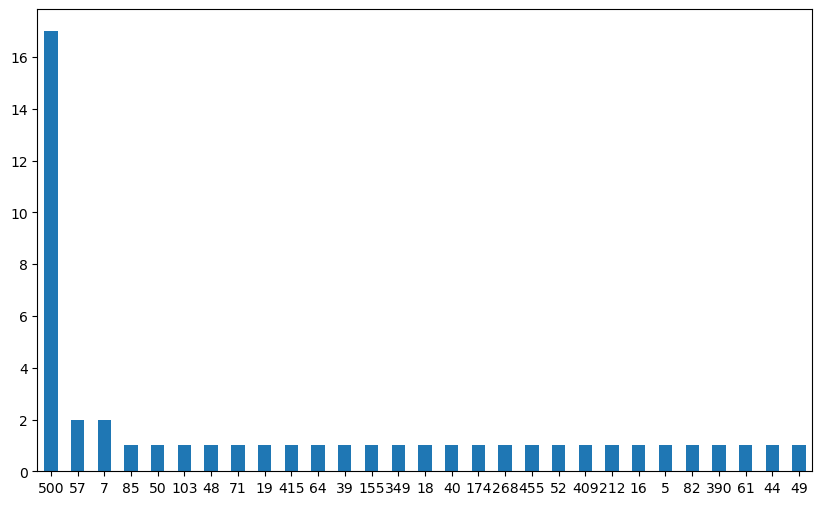

In [73]:
data['connection'].value_counts().plot.bar(rot=0, figsize = (10,6))

<AxesSubplot:ylabel='Frequency'>

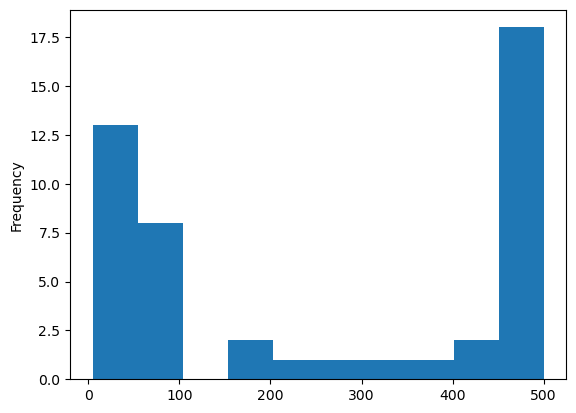

In [74]:
data['connection'].plot.hist()

In [75]:
data.shape

(47, 3)

## Tokenizing 

In [76]:
data['tokens_nltk'] = data['combined'].apply(word_tokenize)

In [77]:
#data.head(2)

## Lemmatization

In [78]:
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return [lemmatizer.lemmatize(w) for w in text]
data['lemmas'] = data.tokens_nltk.apply(lemmatize)

In [79]:
data.head(2)

,id,connection,combined,tokens_nltk,lemmas
0,1,85,c t bauer college of business graduate magna cum laude aspiring human resources professional houston texas,"[c, t, bauer, college, of, business, graduate, magna, cum, laude, aspiring, human, resources, professional, houston, texas]","[c, t, bauer, college, of, business, graduate, magna, cum, laude, aspiring, human, resource, professional, houston, texas]"
1,2,500,native english teacher english program in korea canada,"[native, english, teacher, english, program, in, korea, canada]","[native, english, teacher, english, program, in, korea, canada]"


In [80]:
data['lemmas_combined'] = [','.join(map(str, values)) for values in data['lemmas']]

In [81]:
data['lemmas_combined'] = data['lemmas_combined'].apply(lambda x: remove_symbols(x))

In [82]:
data

,id,connection,combined,tokens_nltk,lemmas,lemmas_combined
0,1,85,c t bauer college of business graduate magna cum laude aspiring human resources professional houston texas,"[c, t, bauer, college, of, business, graduate, magna, cum, laude, aspiring, human, resources, professional, houston, texas]","[c, t, bauer, college, of, business, graduate, magna, cum, laude, aspiring, human, resource, professional, houston, texas]",c t bauer college of business graduate magna cum laude aspiring human resource professional houston texas
1,2,500,native english teacher english program in korea canada,"[native, english, teacher, english, program, in, korea, canada]","[native, english, teacher, english, program, in, korea, canada]",native english teacher english program in korea canada
2,3,44,aspiring human resources professional raleigh durham north carolina area,"[aspiring, human, resources, professional, raleigh, durham, north, carolina, area]","[aspiring, human, resource, professional, raleigh, durham, north, carolina, area]",aspiring human resource professional raleigh durham north carolina area
3,4,500,people development coordinator ryan denton texas,"[people, development, coordinator, ryan, denton, texas]","[people, development, coordinator, ryan, denton, texas]",people development coordinator ryan denton texas
4,5,500,advisory board member celal bayar university izmir turkey,"[advisory, board, member, celal, bayar, university, izmir, turkey]","[advisory, board, member, celal, bayar, university, izmir, turkey]",advisory board member celal bayar university izmir turkey
6,7,61,student humber college aspiring human resources generalist canada,"[student, humber, college, aspiring, human, resources, generalist, canada]","[student, humber, college, aspiring, human, resource, generalist, canada]",student humber college aspiring human resource generalist canada
7,8,500,human resources senior specialist san francisco bay area,"[human, resources, senior, specialist, san, francisco, bay, area]","[human, resource, senior, specialist, san, francisco, bay, area]",human resource senior specialist san francisco bay area
9,10,500,seeking human resources human resources information system generalist positions greater philadelphia area,"[seeking, human, resources, human, resources, information, system, generalist, positions, greater, philadelphia, area]","[seeking, human, resource, human, resource, information, system, generalist, position, greater, philadelphia, area]",seeking human resource human resource information system generalist position greater philadelphia area
11,12,500,senior vice president chief human resources officer marketing communications corporate social responsibility officer engie houston the woodlands energy global professional human resources senior professional human resources houston texas,"[senior, vice, president, chief, human, resources, officer, marketing, communications, corporate, social, responsibility, officer, engie, houston, the, woodlands, energy, global, professional, human, resources, senior, professional, human, resources, houston, texas]","[senior, vice, president, chief, human, resource, officer, marketing, communication, corporate, social, responsibility, officer, engie, houston, the, woodland, energy, global, professional, human, resource, senior, professional, human, resource, houston, texas]",senior vice president chief human resource officer marketing communication corporate social responsibility officer engie houston the woodland energy global professional human resource senior professional human resource houston texas
12,13,500,human resources coordinator intercontinental buckhead atlanta atlanta georgia,"[human, resources, coordinator, intercontinental, buckhead, atlanta, atlanta, georgia]","[human, resource, coordinator, intercontinental, buckhead, atlanta, atlanta, georgia]",human resource coordinator intercontinental buckhead atlanta atlanta georgia


In [83]:
data.rename(columns = {'id': 'Candidate_ID'}, inplace = True)

In [84]:
data.columns

Index(['Candidate_ID', 'connection', 'combined', 'tokens_nltk', 'lemmas',
       'lemmas_combined'],
      dtype='object')

In [85]:
data.drop(['combined', 'tokens_nltk', 'lemmas'], axis = 1, inplace = True)

# BERT 
https://github.com/UKPLab/sentence-transformers/tree/master/examples/training/sts

We are given the keywords as part of the project brief. 

**Keywords**
“Aspiring human resources” or “seeking human resources”

In [86]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [87]:
keywords = 'aspiring human resources'
corpus = data['lemmas_combined'].tolist()
embedding_sentences = model.encode([keywords]+corpus)
cosine_similarities_bert = cosine_similarity(embedding_sentences[0:1], embedding_sentences).flatten()
scores = [item.item() for item in cosine_similarities_bert[1:]]
data['bert_aspiring'] = scores

In [88]:
keywords = 'seeking human resources'
corpus = data['lemmas_combined'].tolist()
embedding_sentences = model.encode([keywords]+corpus)
cosine_similarities_bert = cosine_similarity(embedding_sentences[0:1], embedding_sentences).flatten()
scores = [item.item() for item in cosine_similarities_bert[1:]]
data['bert_seeking'] = scores

In [89]:
data.sort_values(by='bert_seeking', ascending = False).head()

,Candidate_ID,connection,lemmas_combined,bert_aspiring,bert_seeking
98,99,48,seeking human resource position la vega nevada area,0.633180,0.758671
27,28,390,seeking human resource opportunity chicago illinois,0.685325,0.753176
2,3,44,aspiring human resource professional raleigh durham north carolina area,0.831576,0.735609
9,10,500,seeking human resource human resource information system generalist position greater philadelphia area,0.661725,0.720230
100,101,500,human resource generalist loparex raleigh durham north carolina area,0.662054,0.702518


In [90]:
data.sort_values(by='bert_aspiring', ascending = False, inplace = True)

In [91]:
data.rename(columns={'bert_aspiring':'bert_score'}, inplace = True)

In [92]:
data.reset_index(inplace = True)
data

,index,Candidate_ID,connection,lemmas_combined,bert_score,bert_seeking
0,2,3,44,aspiring human resource professional raleigh durham north carolina area,0.831576,0.735609
1,99,100,103,aspiring human resource manager graduating may seeking entry level human resource position in st louis cape girardeau missouri,0.736301,0.657286
2,27,28,390,seeking human resource opportunity chicago illinois,0.685325,0.753176
3,6,7,61,student humber college aspiring human resource generalist canada,0.679200,0.598220
4,26,27,500,aspiring human resource management student seeking internship houston texas,0.668053,0.599387
5,96,97,71,aspiring human resource professional kokomo indiana area,0.663389,0.638800
6,100,101,500,human resource generalist loparex raleigh durham north carolina area,0.662054,0.702518
7,9,10,500,seeking human resource human resource information system generalist position greater philadelphia area,0.661725,0.720230
8,71,72,5,business management major aspiring human resource manager monroe louisiana area,0.655646,0.577005
9,73,74,16,human resource professional greater boston area,0.647814,0.651938


In [93]:
data.columns

Index(['index', 'Candidate_ID', 'connection', 'lemmas_combined', 'bert_score',
       'bert_seeking'],
      dtype='object')

In [94]:
data.reset_index(inplace = True)

In [95]:
data.drop(['index', 'bert_seeking'], axis = 1, inplace = True)
data.rename(columns={'level_0': 'Bert_Ranking'}, inplace = True)

In [96]:
data

,Bert_Ranking,Candidate_ID,connection,lemmas_combined,bert_score
0,0,3,44,aspiring human resource professional raleigh durham north carolina area,0.831576
1,1,100,103,aspiring human resource manager graduating may seeking entry level human resource position in st louis cape girardeau missouri,0.736301
2,2,28,390,seeking human resource opportunity chicago illinois,0.685325
3,3,7,61,student humber college aspiring human resource generalist canada,0.679200
4,4,27,500,aspiring human resource management student seeking internship houston texas,0.668053
5,5,97,71,aspiring human resource professional kokomo indiana area,0.663389
6,6,101,500,human resource generalist loparex raleigh durham north carolina area,0.662054
7,7,10,500,seeking human resource human resource information system generalist position greater philadelphia area,0.661725
8,8,72,5,business management major aspiring human resource manager monroe louisiana area,0.655646
9,9,74,16,human resource professional greater boston area,0.647814


## Re-ranking candidates based on User Input

We want the user to rank/select the best candidate from the ordered list. I am going to select the 7th candidate candidate from the ranked dataframe, which is candidate with id number 101

In [97]:
starred_candidate = []
do_you_see_suitable_candidate = input("Do you want to star any candidates? Enter 'Yes' or 'No': ")
if do_you_see_suitable_candidate.lower() == 'yes':
    starred_candidate = [int(item) for item in input("Enter id of candidate you want to star: ").split()]

Do you want to star any candidates? Enter 'Yes' or 'No': yes
Enter id of candidate you want to star: 101


In [98]:
print(starred_candidate)

[101]


In [99]:
#extract the job description which was picked out to be the most suitable candidate
keywords = []
for x in starred_candidate:
    keywords.append(data[data['Candidate_ID']==x]['lemmas_combined'].astype('str'))

In [100]:
print(keywords)

[6    human resource generalist loparex raleigh durham north carolina area
Name: lemmas_combined, dtype: object]


In [101]:
corpus = data['lemmas_combined'].tolist()
embedding_sentences = model.encode([keywords]+corpus)
cosine_similarities_bert = cosine_similarity(embedding_sentences[0:1], embedding_sentences).flatten()
scores = [item.item() for item in cosine_similarities_bert[1:]]
data['new_bert_score'] = scores

In [102]:
data.sort_values(by='new_bert_score', ascending = False, inplace = True)

In [103]:
data.reset_index(inplace = True)

In [104]:
data.reset_index(inplace = True)

In [105]:
data.drop('index', axis = 1, inplace = True)
data.rename(columns={'level_0': 'Re-ranked'}, inplace = True)

In [106]:
data

,Re-ranked,Bert_Ranking,Candidate_ID,connection,lemmas_combined,bert_score,new_bert_score
0,0,6,101,500,human resource generalist loparex raleigh durham north carolina area,0.662054,0.767724
1,1,22,71,500,human resource generalist scottmadden inc raleigh durham north carolina area,0.575161,0.574465
2,2,0,3,44,aspiring human resource professional raleigh durham north carolina area,0.831576,0.535990
3,3,30,69,500,director of human resource north america groupe beneteau greater grand rapid michigan area,0.490219,0.500866
4,4,7,10,500,seeking human resource human resource information system generalist position greater philadelphia area,0.661725,0.499360
5,5,24,68,500,human resource specialist luxottica greater new york city area,0.563400,0.482442
6,6,9,74,16,human resource professional greater boston area,0.647814,0.468390
7,7,15,88,18,human resource management major milpitas california,0.607392,0.448459
8,8,12,99,48,seeking human resource position la vega nevada area,0.633180,0.448267
9,9,3,7,61,student humber college aspiring human resource generalist canada,0.679200,0.445103


## Conclusion

I wrote few functions to clean the dataset by changing everything to lowercase, removing symbols, numerical values, and accents. However, a large part of the data cleaning processes were done manually. Such as identifying accornyms and expanding them, deciding on removing candidates based on the number of connections. There are long term solutions that we can develop to automate a large part of this process. One posisble idea is to keep a running dictionary with common accronyms used for job titles in certain sectors and their expanded terms. Secondly, here we weren't made aware of a specific role or amount of experience an ideal candidate requires. This meant I made a decision to disregard candidates with single digit connections. However, if we are looking for entry level candidates, then we should have kept candidates with lower number of connections. Contrastingly if we were interested in senior level candidates, then I would have set the threshold for a higher number, say 300+ number of connections. I believe filtering based on connections is a good idea for a larger and more general solution to this problem. 

I chose to include the locations of the candidates as part of the corpus. There are advantages and disadvantages of doing this. If the candidate of interest must be in a certain location then by including the location as aprt of the job description, a closer match can be identified. However, this could also introduce bias in our selection method, as at the end of the day, a person would be choosing which candidate to rank manually. 

A potential ammendment to this project could be to take the initial keywords as user input so the intial ranking of the candidates is bassed on the input, which can be for other roles. If this were to be implemented a larger dataset would be required to test the valdiity of the method. One advantage of having a larger dataset where the intial rnaking of the dandidates is based on user input is the retention of high value candidates for multiple positions. 
